### **Study notes on the variance-bias tradeoff**

*Based on James et al. (2017) An Introduction to statistical learning*

Variance and bias refer to how model predictions **_vary upon replication_**. That is, if we re-sampled the population many times and generated many training sets, trained the model each time and made predictions for a given (i.e., fixed) test dataset, how variable would those predictions be at each test datapoint $x_0$? And also, how close to $y_0$ would the expected value of those predictions be? The first question refers to variance, and the second to bias. 

Why is this important at all? Well, throughout all of statistics and science, **_every dataset is a sample_**, no matter how big, and we need to know how our modelling results would vary if we repeated the sampling. In other words, we must acknowledge that our dataset is just **_one realization_** out of very many (which together make up the distribution). For that reason, we must always think in terms of expected values and variances of things that **_vary upon replication_**. 

For each re-sampling, we can measure model error at a single test datapoint $x_0$ as $(y_0 - \hat{f}(x_0))^2$, i.e., a squared error (focusing on regression here, something similar can be done for classification problems). And because that quantity would also vary upon replication, what's interesting is not the individual realizations but their expected value as a whole, i.e., as a random variable, $E(y_0 - \hat{f}(x_0))^2$. 

It turns out that $E(y_0 - \hat{f}(x_0))^2$ (the expected value of the squared error at a single point $x_0$) is equal to the sum of three quanitities:

- $\textrm{Var}(\hat{f}(x_0))$ = the variance of the predictions at $x_0$
- $[\textrm{Bias}(\hat{f}(x_0))]^2$ = The squared bias of the predictions at $x_0$
- $\textrm{Var}(\epsilon)$ = the population variance, i.e., the irreducible error

The irreducible error is a property of the population, _not the result of sampling_, so it will always exist. Actually, it represents the maximum theoretical model quality, i.e., our models will never have an error smaller than $\textrm{Var}(\epsilon)$, which is the error we'd get if we could somehow magically sample the entire population.

The first term measures how variable the $\hat{f}(x_0)$ are across replications. For models that are inflexible, like a linear regression, this quantity tends to be smaller that for more complex models, like splines, higher-order polynomials, etc. The reason is simple - with varying training datapoints (upon replication), a simple equation like $a + bx$ can only produce lines of different intercept and slope. In contrast, something like a spline, with many more parameters and more complex structure (structure = the way the inputs are combined to produced the output), can lead to more widely varying shapes and therefore more varying predictions $\hat{f}(x_0)$.

Finally, bias measures how much the expected value of $\hat{f}(x_0)$ deviates from the test datapoint $y_0$.

The above can be easily extended from a single test datapoint $(x_0, y_0)$ to the entire dataset by averaging $\textrm{Var}(\hat{f}(x_0))$ and $[\textrm{Bias}(\hat{f}(x_0))]^2$ over all test datapoints.

This is illustrated below with a simple experiment.


#### **Numerical experiment to illustrate variance-bias tradeoff**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.lines import Line2D

The experiment defines a population and then resamples it many times to make several training sets, each time fitting a model and making predictions for all test datapoints. Before resampling, a set of datapoints from the population is separated out to be used as test set. This is done only once, since bias and variance are measured with respect to a given (fixed) test set. This process is repeated for models with increasing levels of flexibility (polynomials).

The parameters below control the size of the population and of the training and test samples, as well as the type of true function underlying the population (an order-5 polynomial) and the range of flexibility of the models to be fit to the training data (also polynomials).

In [38]:
# define_experiment_parameters
f = Polynomial([1, -2, -1, 1, -1, -1])
sigma = 0.7
population_size = 1000
train_sample_size = 100
test_sample_size = 50
flexibility = range(0, 15)

Next, we first split the population into a train and test population, and then sample once from the latter randomly to produce the test set for the experiment.

In [39]:
def make_train_population_and_test_sample():
    epsilon = np.random.normal(0, sigma, population_size)
    x_population = np.linspace(-1, 1, population_size)
    y_population = f(x_population) + epsilon
    X_train_population, X_test_population, y_train_population, y_test_population = train_test_split(
        x_population, 
        y_population, 
        test_size=0.3, 
        random_state=42
    )

    test_sample_indices = np.random.choice(X_test_population.shape[0], size=test_sample_size)
    X_test_sample, y_test_sample = X_test_population[test_sample_indices], y_test_population[test_sample_indices]

    return {
        'X_train_population': X_train_population,
        'y_train_population': y_train_population,
        'X_test_population': X_test_population,
        'y_test_population': y_test_population,
        'X_test_sample': X_test_sample,
        'y_test_sample': y_test_sample,
    }

train_population_and_test_sample = make_train_population_and_test_sample()

Then we run the experiment - iterate over all flexibility levels (polynomial orders), each time resampling the training population 20 times. At each resampling, a polynomial is fit, predictions are made and their variance, bias and mse are computed and stored.

In [40]:

def run_experiment(train_population_and_test_sample):

    bias_squared, variance, mse = [], [], []
    y_hat_flex, models_flex = [], []

    for flex in flexibility:
        y_hat_samples = []
        mse_samples = []
        for i in range(20):
            train_sample_indices = np.random.choice(
                train_population_and_test_sample['X_train_population'].shape[0], 
                size=train_sample_size
            )
            X_train_sample = train_population_and_test_sample['X_train_population'][train_sample_indices]
            y_train_sample = train_population_and_test_sample['y_train_population'][train_sample_indices]
            model = Polynomial.fit(X_train_sample, y_train_sample, flex)
            y_hat = model(train_population_and_test_sample['X_test_sample'])
            y_hat_samples.append(y_hat)
            mse_samples.append(np.mean((y_hat - train_population_and_test_sample['y_test_sample'])**2))

        models_flex.append(model)
        y_hat_flex.append(y_hat_samples)
        bias_squared.append(np.mean((np.mean(y_hat_samples, axis=0) - train_population_and_test_sample['y_test_sample'])**2))
        variance.append(np.mean(np.var(y_hat_samples, axis=0)))
        mse.append(np.mean(mse_samples))

    y_hat_flex = np.array(y_hat_flex)

    return {
        'models_flex': models_flex,
        'y_hat_flex': y_hat_flex,
        'bias_squared': bias_squared,
        'variance': variance,
        'mse': mse,

    }


results = run_experiment(train_population_and_test_sample)

Finally, results are plotted. The three graphs below show three key elements of the bias-variance tradeoff:

- On the left, the test data are plotted alongside three of the fitted polynomials: order 0 (`model_0`), order 1 (`model_1`), order 3 (`model_3`) and order 10 (`model_10`). It is clear how higher-order polynomials can lead to more flexible predictions.

- In the middle, the average bias, average variance and average MSE across all replications are computed for each level of flexibility. As expected, lower-order models have more bias and less variance. As model complexity/flexibility grows, bias goes down, as the model is able to hit more datapoints, and variance goes up, since predictions become more volatile across replicates.

- The graph on the right illustrates this last fact for three test datapoints (black points). For each datapoint, predictions from all replications are plotted as blue and red dots, where blue predictions correspond to low flexibility and red to high flexibility. The numbers at the top correspond to the average $\textrm{Var}(\hat{f}(x_0))$, which is higher for the high-flexibility models (red).

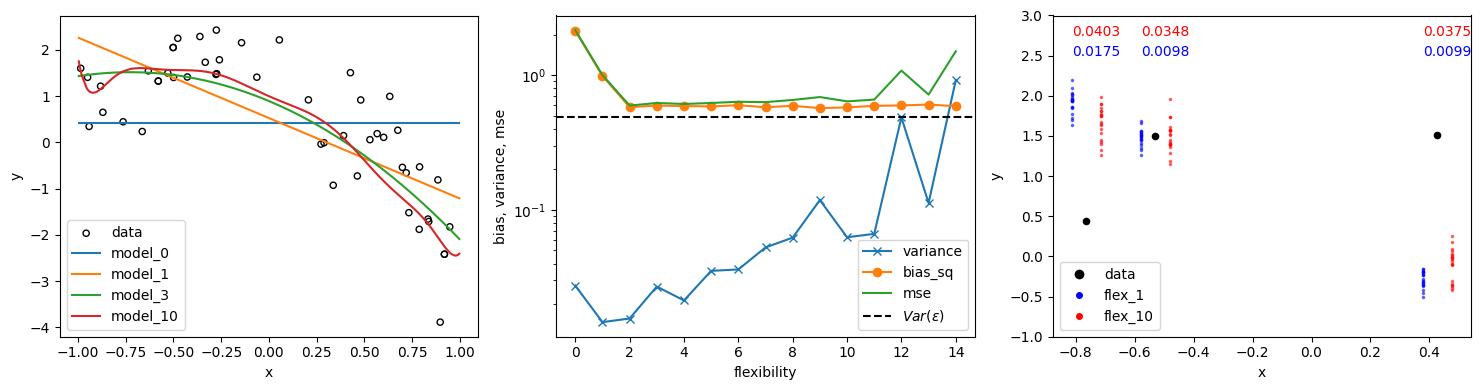

In [41]:
def plot_results(train_population_and_test_sample, results):

    X_test_population_sorted = np.sort(train_population_and_test_sample['X_test_population'])


    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # Test data and some fitted models
    ax[0].set_ylabel('y')
    ax[0].set_xlabel('x')
    ax[0].scatter(
        train_population_and_test_sample['X_test_sample'], 
        train_population_and_test_sample['y_test_sample'], 
        s=20, edgecolor='black', facecolor='none', label='data'
    )
    for i in [0, 1, 3, 10]:
        ax[0].plot(X_test_population_sorted, results['models_flex'][i](X_test_population_sorted), label=f'model_{i}')
    ax[0].legend()

    # MSE, variance and bias at each level of flexibility
    ax[1].set_ylabel('bias, variance, mse')
    ax[1].set_xlabel('flexibility')
    ax[1].plot(flexibility, results['variance'], label='variance', marker='x')
    ax[1].plot(flexibility, results['bias_squared'], label='bias_sq', marker='o')
    ax[1].plot(flexibility, results['mse'], label='mse')
    ax[1].axhline(y=sigma**2, linestyle='--', color='black', label=r'$Var(\epsilon)$')
    ax[1].set_yscale('log')
    ax[1].legend()


    # Example points and variability of predictions for two levels of flexibility

    idx = [0, 5, 10]

    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    ax[2].scatter(
        train_population_and_test_sample['X_test_sample'][idx], 
        train_population_and_test_sample['y_test_sample'][idx], 
        s=20, c='black', label='data'
    )

    # plot individual predictions for flexibility level 1
    for i in range(results['y_hat_flex'][1, :, idx].shape[1]):
        ax[2].scatter(
            train_population_and_test_sample['X_test_sample'][idx] - 0.05, 
            results['y_hat_flex'][1, i, idx], 
            s=10, c='blue', alpha=0.5, marker='.'
        )

    # plot individual predictions for flexibility level 10
    for i in range(results['y_hat_flex'][10, :, idx].shape[1]):
        ax[2].scatter(
            train_population_and_test_sample['X_test_sample'][idx] + 0.05, 
            results['y_hat_flex'][10, i, idx], 
            s=10, c='red', alpha=0.5, marker='.'
        )

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='data'),
        Line2D([0], [0], linestyle='None', marker='.', color='blue', markersize=8, label='flex_1'),
        Line2D([0], [0], linestyle='None', marker='.', color='red', markersize=8, label='flex_10')
    ]

    var_1 = np.var(results['y_hat_flex'][1, :, idx], axis=1)
    var_10 = np.var(results['y_hat_flex'][10, :, idx], axis=1)

    for (v, x) in zip(var_1, train_population_and_test_sample['X_test_sample'][idx]):
        ax[2].text(x=x-0.05, y=2.5, s=f'{v:.4f}', c='blue')
    for (v, x) in zip(var_10, train_population_and_test_sample['X_test_sample'][idx]):
        ax[2].text(x=x-0.05, y=2.75, s=f'{v:.4f}', c='red')
        

    ax[2].legend(handles=legend_elements)
    ax[2].set_ylim(-1, 3)

    plt.tight_layout()
    plt.show()

plot_results(train_population_and_test_sample, results)